In [1]:
## !pip install SQLAlchemy pandas matplotlib PyMySQL

Enter the room number to update:  20


Initial Price: 5000
Room Type Adjustment: 5500 (+10.00%)
Weekend Surge Charge: 5500 (No Change)
Summer Season Adjustment: 6324 (+15.00%)
Room Availability Charge: 7462 (+18.00%)
Loyalty Discount: 5969 (-20.01%)
Special Offer Period: 5969 (No Change)
Final price updated successfully for room 20 to 5969.
   id  room_no  price room_type  currently_booked          created_at
0  18       20   5969         N                 0 2024-07-18 22:01:37


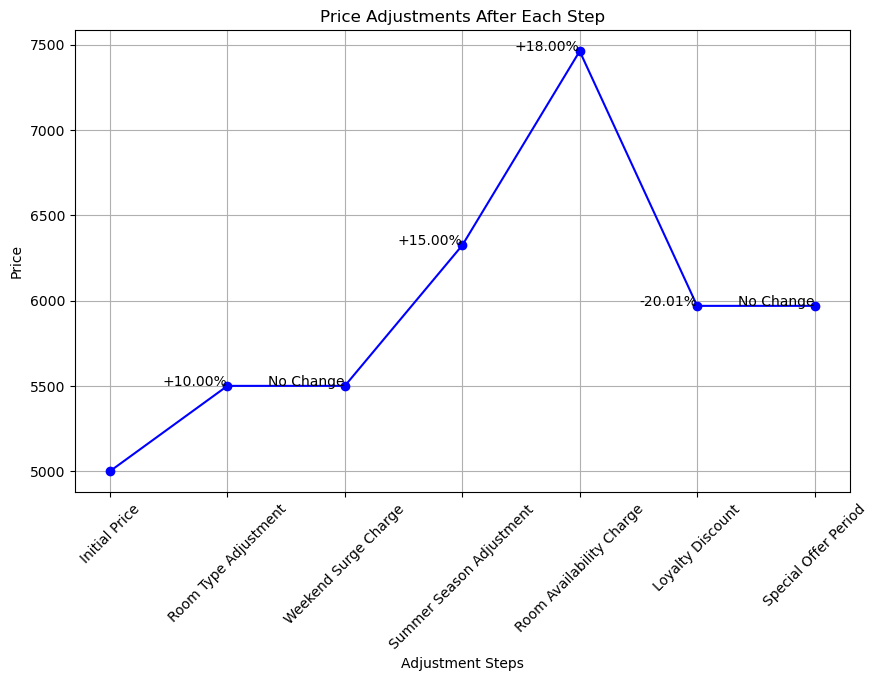

In [2]:
# FINAL MODEL - DO NOT CHANGE
from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Database connection parameters
username = 'root'
password = 'iamukr77'
host = 'localhost'
port = '3306'  # Default MySQL port
database = 'hms'  # Your schema name

# Create an engine instance with provided credentials
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Define the ORM base class
Base = declarative_base()

# Define the ORM mapping for the rooms table
class Room(Base):
    __tablename__ = 'rooms'
    id = Column(Integer, primary_key=True, autoincrement=True)
    room_no = Column(Integer, unique=True)
    price = Column(Integer)
    room_type = Column(String(2))
    currently_booked = Column(Boolean, default=False)
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="room")

# Define the ORM mapping for the reservations table
class Reservation(Base):
    __tablename__ = 'reservations'
    id = Column(Integer, primary_key=True, autoincrement=True)
    g_id = Column(Integer, ForeignKey('guests.id'))
    r_date = Column(DateTime)
    check_in = Column(DateTime)
    check_out = Column(DateTime)
    meal = Column(Boolean)
    r_id = Column(Integer, ForeignKey('rooms.id'))
    r_type = Column(String(2))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    guest = relationship("Guest", back_populates="reservations")
    room = relationship("Room", back_populates="reservations")

# Define the ORM mapping for the guests table
class Guest(Base):
    __tablename__ = 'guests'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(30))
    address = Column(String(50))
    email_id = Column(String(50))
    phone = Column(Integer)
    city = Column(String(20))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="guest")

# Create a sessionmaker
Session = sessionmaker(bind=engine)

# Function to calculate dynamic price based on room type, weekends, and summer season
def calculate_dynamic_price(room, reservation):
    prices = []
    labels = []
    changes = []
    
    base_price = 5000  # Example base price
    prices.append(base_price)
    labels.append('Initial Price')
    changes.append('')
    print(f"Initial Price: {base_price}")
    
    # Adjust price based on room type
    previous_price = base_price
    if room.room_type == 'D':  # Deluxe room
        base_price += 1000
    elif room.room_type == 'N':  # Normal room
        base_price += 500
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(base_price)
    labels.append('Room Type Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Room Type Adjustment: {base_price} ({changes[-1]})")
    
    # Check if the check_in date was a weekend
    previous_price = base_price
    created_at_date = reservation.check_in
    is_weekend_flag = created_at_date.weekday() >= 5  # 5 represents Saturday, 6 represents Sunday

    if is_weekend_flag:
        base_price *= 1.05  # Increase price by 5% for rooms created on weekends
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Weekend Surge Charge')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Weekend Surge Charge: {int(base_price)} ({changes[-1]})")
    
    # Check if the created_at date falls within the summer season (March and April)
    previous_price = base_price
    if created_at_date.month in [3, 4]:
        base_price *= 1.15  # Increase price by 15% for rooms booked during the summer season
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Summer Season Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Summer Season Adjustment: {int(base_price)} ({changes[-1]})")
    
    return int(base_price), prices, labels, changes

# Function to check if the room is booked
def is_room_booked(room_no, session):
    reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out == None).first()
    return reservation is not None

# Function to apply dynamic price based on room availability
def update_room_price(room_no, session, current_price):
    previous_price = current_price
    if is_room_booked(room_no, session):
        current_price *= 1.18  # Increase price by 18%
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Room Availability Charge: {int(current_price)} ({f'+{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return int(current_price), f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply loyalty discount
def apply_loyalty_discount(current_price, guest):
    previous_price = current_price
    if guest.email_id == 'ukr@abc.com':
        current_price = int(current_price * 0.8)  # Apply 20% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Loyalty Discount: {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply special offer period specific date
def apply_special_offer(current_price, reservation):
    previous_price = current_price
    offer_start_date = datetime.datetime(2024, 3, 10)
    offer_end_date = datetime.datetime(2024, 3, 30)
    
    if offer_start_date <= reservation.check_in <= offer_end_date:
        current_price = int(current_price * 0.93)  # Apply 7% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Special Offer Period: {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Main function to update room price
def update_room_price_main():
    try:
        # Create a session
        session = Session()
        
        # Take room number input from the user
        room_number_to_update = int(input("Enter the room number to update: "))
        
        # Fetch the room with the specific room_no
        room = session.query(Room).filter_by(room_no=room_number_to_update).first()
    
        if room:
            # Fetch the reservation associated with the room
            reservation = session.query(Reservation).filter_by(r_id=room.id, check_out=None).first()
    
            if reservation:
                # Fetch the guest associated with the reservation
                guest = session.query(Guest).filter_by(id=reservation.g_id).first()
    
                # Calculate the new dynamic price
                new_price, prices, labels, changes = calculate_dynamic_price(room, reservation)
    
                # Apply dynamic price based on room availability
                new_price, change = update_room_price(room.room_no, session, new_price)
                prices.append(new_price)
                labels.append('Room Availability Charge')
                changes.append(change)
    
                # Apply loyalty discount if applicable
                new_price, change = apply_loyalty_discount(new_price, guest)
                prices.append(new_price)
                labels.append('Loyalty Discount')
                changes.append(change)
                
                # Apply special offer period specific date
                new_price, change = apply_special_offer(new_price, reservation)
                prices.append(new_price)
                labels.append('Special Offer Period')
                changes.append(change)
    
                # Update the price in the database
                room.price = new_price
                session.commit()  # Commit the changes
                print(f"Final price updated successfully for room {room_number_to_update} to {new_price}.")
                
                # To verify the update, fetch the data again and display the updated DataFrame
                query = f"SELECT * FROM rooms WHERE room_no = {room_number_to_update}"
                data = pd.read_sql(query, engine)
                print(data)
    
                # Plot the price changes
                plt.figure(figsize=(10, 6))
                plt.plot(labels, prices, marker='o', linestyle='-', color='b')
                for i, (label, price, change) in enumerate(zip(labels, prices, changes)):
                    plt.text(i, price, f'{change}', ha='right')
                plt.xlabel('Adjustment Steps')
                plt.ylabel('Price')
                plt.title('Price Adjustments After Each Step')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
    
            else:
                print(f"No active reservation found for room number {room_number_to_update}.")
    
        else:
            print(f"No room found with number {room_number_to_update}.")
    
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the session
        session.close()

# Execute the main function
update_room_price_main()


Enter the room number to update:  18


Initial Price: 5000
Room Type Adjustment: 6000 (+20.00%)
Weekend Surge Charge: 6000 (No Change)
Summer Season Adjustment: 6899 (+15.00%)
Room Availability Charge: 8140 (+18.00%)
Loyalty Discount: 8140 (No Change)
Special Offer Period: 8140 (No Change)
Final price updated successfully for room 18 to 8140.
   id  room_no  price room_type  currently_booked          created_at
0  16       18   8140         D                 0 2024-07-18 10:16:15


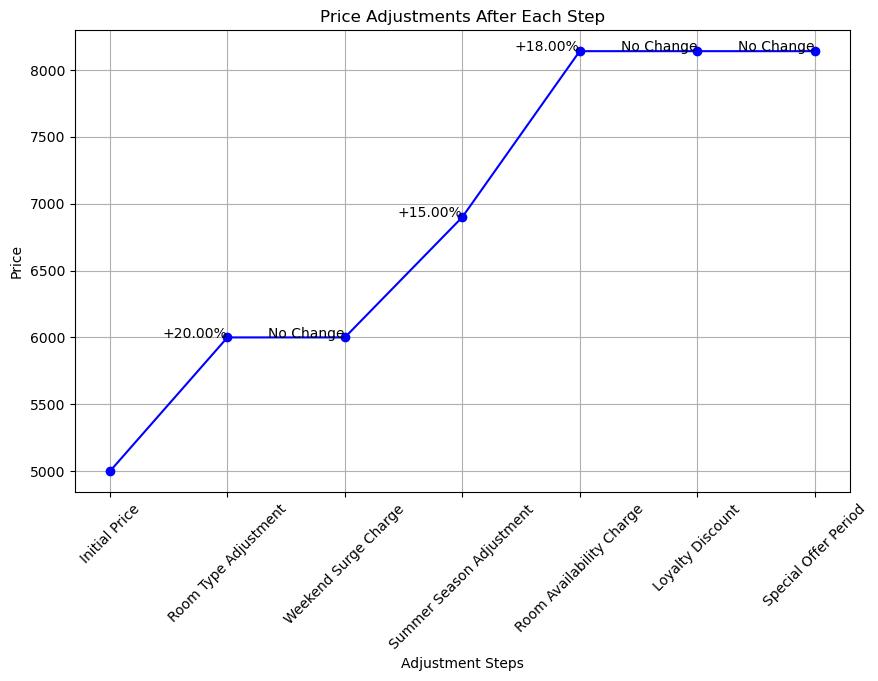

In [2]:
# final model 
from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Database connection parameters
username = 'root'
password = 'iamukr77'
host = 'localhost'
port = '3306'  # Default MySQL port
database = 'hms'  # Your schema name

# Create an engine instance with provided credentials
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Define the ORM base class
Base = declarative_base()

# Define the ORM mapping for the rooms table
class Room(Base):
    __tablename__ = 'rooms'
    id = Column(Integer, primary_key=True, autoincrement=True)
    room_no = Column(Integer, unique=True)
    price = Column(Integer)
    room_type = Column(String(2))
    currently_booked = Column(Boolean, default=False)
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="room")

# Define the ORM mapping for the reservations table
class Reservation(Base):
    __tablename__ = 'reservations'
    id = Column(Integer, primary_key=True, autoincrement=True)
    g_id = Column(Integer, ForeignKey('guests.id'))
    r_date = Column(DateTime)
    check_in = Column(DateTime)
    check_out = Column(DateTime)
    meal = Column(Boolean)
    r_id = Column(Integer, ForeignKey('rooms.id'))
    r_type = Column(String(2))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    guest = relationship("Guest", back_populates="reservations")
    room = relationship("Room", back_populates="reservations")

# Define the ORM mapping for the guests table
class Guest(Base):
    __tablename__ = 'guests'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(30))
    address = Column(String(50))
    email_id = Column(String(50))
    phone = Column(Integer)
    city = Column(String(20))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="guest")

# Create a sessionmaker
Session = sessionmaker(bind=engine)

# Function to calculate dynamic price based on room type, weekends, and summer season
def calculate_dynamic_price(room, reservation):
    prices = []
    labels = []
    changes = []
    
    base_price = 5000  # Example base price
    prices.append(base_price)
    labels.append('Initial Price')
    changes.append('')
    print(f"Initial Price: {base_price}")
    
    # Adjust price based on room type
    previous_price = base_price
    if room.room_type == 'D':  # Deluxe room
        base_price += 1000
    elif room.room_type == 'N':  # Normal room
        base_price += 500
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(base_price)
    labels.append('Room Type Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Room Type Adjustment: {base_price} ({changes[-1]})")
    
    # Check if the created_at date was a weekend
    previous_price = base_price
    created_at_date = reservation.created_at
    is_weekend_flag = created_at_date.weekday() >= 5  # 5 represents Saturday, 6 represents Sunday

    if is_weekend_flag:
        base_price *= 1.05  # Increase price by 5% for rooms created on weekends
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Weekend Surge Charge')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Weekend Surge Charge: {int(base_price)} ({changes[-1]})")
    
    # Check if the created_at date falls within the summer season (March and April)
    previous_price = base_price
    if created_at_date.month in [3, 4]:
        base_price *= 1.15  # Increase price by 15% for rooms booked during the summer season
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Summer Season Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Summer Season Adjustment: {int(base_price)} ({changes[-1]})")
    
    return int(base_price), prices, labels, changes

# Function to check if the room is booked
def is_room_booked(room_no, session):
    reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out == None).first()
    return reservation is not None

# Function to apply dynamic price based on room availability
def update_room_price(room_no, session, current_price):
    previous_price = current_price
    if is_room_booked(room_no, session):
        current_price *= 1.18  # Increase price by 18%
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Room Availability Charge: {int(current_price)} ({f'+{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return int(current_price), f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply loyalty discount
def apply_loyalty_discount(current_price, guest):
    previous_price = current_price
    if guest.email_id == 'ukr@abc.com':
        current_price = int(current_price * 0.8)  # Apply 20% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Loyalty Discount: {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply special offer period specific date
def apply_special_offer(current_price, reservation):
    previous_price = current_price
    offer_start_date = datetime.datetime(2024, 7, 10)
    offer_end_date = datetime.datetime(2024, 7, 30)
    
    if offer_start_date <= reservation.created_at <= offer_end_date:
        current_price = int(current_price * 0.93)  # Apply 7% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Special Offer Period: {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Main function to update room price
def update_room_price_main():
    try:
        # Create a session
        session = Session()
        
        # Take room number input from the user
        room_number_to_update = int(input("Enter the room number to update: "))
        
        # Fetch the room with the specific room_no
        room = session.query(Room).filter_by(room_no=room_number_to_update).first()
    
        if room:
            # Fetch the reservation associated with the room
            reservation = session.query(Reservation).filter_by(r_id=room.id, check_out=None).first()
    
            if reservation:
                # Fetch the guest associated with the reservation
                guest = session.query(Guest).filter_by(id=reservation.g_id).first()
    
                # Calculate the new dynamic price
                new_price, prices, labels, changes = calculate_dynamic_price(room, reservation)
    
                # Apply dynamic price based on room availability
                new_price, change = update_room_price(room.room_no, session, new_price)
                prices.append(new_price)
                labels.append('Room Availability Charge')
                changes.append(change)
    
                # Apply loyalty discount if applicable
                new_price, change = apply_loyalty_discount(new_price, guest)
                prices.append(new_price)
                labels.append('Loyalty Discount')
                changes.append(change)
                
                # Apply special offer period specific date
                new_price, change = apply_special_offer(new_price, reservation)
                prices.append(new_price)
                labels.append('Special Offer Period')
                changes.append(change)
    
                # Update the price in the database
                room.price = new_price
                session.commit()  # Commit the changes
                print(f"Final price updated successfully for room {room_number_to_update} to {new_price}.")
                
                # To verify the update, fetch the data again and display the updated DataFrame
                query = f"SELECT * FROM rooms WHERE room_no = {room_number_to_update}"
                data = pd.read_sql(query, engine)
                print(data)
    
                # Plot the price changes
                plt.figure(figsize=(10, 6))
                plt.plot(labels, prices, marker='o', linestyle='-', color='b')
                for i, (label, price, change) in enumerate(zip(labels, prices, changes)):
                    plt.text(i, price, f'{change}', ha='right')
                plt.xlabel('Adjustment Steps')
                plt.ylabel('Price')
                plt.title('Price Adjustments After Each Step')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
            else:
                print(f"No reservation found for room number {room_number_to_update}.")
        else:
            print(f"Room number {room_number_to_update} not found.")
    
    except Exception as e:
        session.rollback()  # Rollback the changes on error
        print(f"An error occurred: {e}")
    finally:
        session.close()  # Close the session

# Execute the main function
if __name__ == "__main__":
    update_room_price_main()


Enter the room number to update:  19


Initial Price: 5000
Room Type Adjustment: 5500 (+10.00%)
Weekend Surge Charge: 5500 (No Change)
Summer Season Adjustment: 5500 (No Change)
Room Availability Charge: 6490 (+18.00%)
Loyalty Discount: 5192 (-20.00%)
Special Offer Period: 4828 (-7.01%)
Final price updated successfully for room 19 to 4828.
   id  room_no  price room_type  currently_booked          created_at
0  17       19   4828         N                 0 2024-07-18 12:35:19


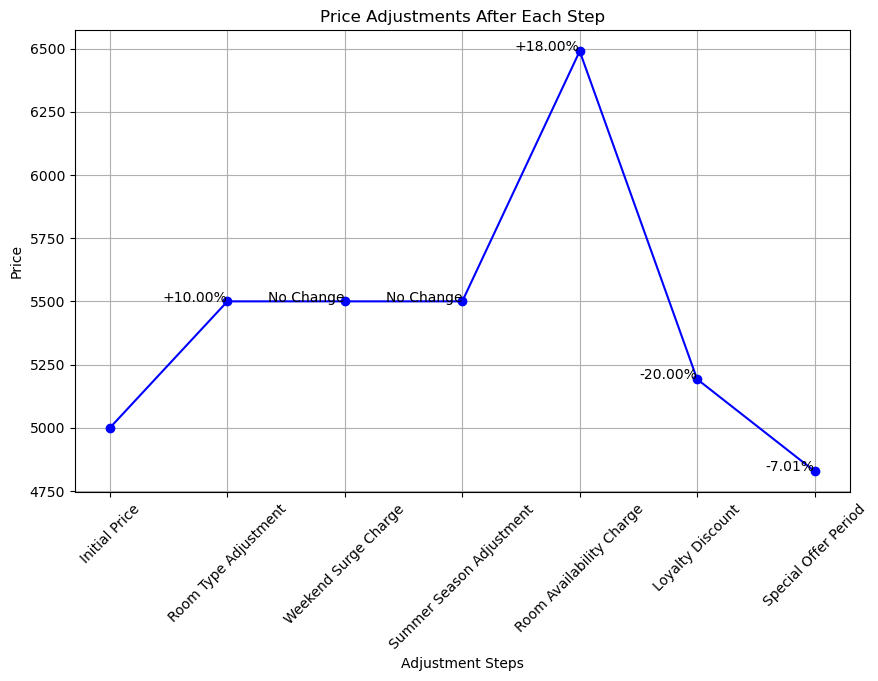

In [3]:
# FINAL MODEL - DO NOT CHANGE
from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Database connection parameters
username = 'root'
password = 'iamukr77'
host = 'localhost'
port = '3306'  # Default MySQL port
database = 'hms'  # Your schema name

# Create an engine instance with provided credentials
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Define the ORM base class
Base = declarative_base()

# Define the ORM mapping for the rooms table
class Room(Base):
    __tablename__ = 'rooms'
    id = Column(Integer, primary_key=True, autoincrement=True)
    room_no = Column(Integer, unique=True)
    price = Column(Integer)
    room_type = Column(String(2))
    currently_booked = Column(Boolean, default=False)
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="room")

# Define the ORM mapping for the reservations table
class Reservation(Base):
    __tablename__ = 'reservations'
    id = Column(Integer, primary_key=True, autoincrement=True)
    g_id = Column(Integer, ForeignKey('guests.id'))
    r_date = Column(DateTime)
    check_in = Column(DateTime)
    check_out = Column(DateTime)
    meal = Column(Boolean)
    r_id = Column(Integer, ForeignKey('rooms.id'))
    r_type = Column(String(2))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    guest = relationship("Guest", back_populates="reservations")
    room = relationship("Room", back_populates="reservations")

# Define the ORM mapping for the guests table
class Guest(Base):
    __tablename__ = 'guests'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(30))
    address = Column(String(50))
    email_id = Column(String(50))
    phone = Column(Integer)
    city = Column(String(20))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="guest")

# Create a sessionmaker
Session = sessionmaker(bind=engine)

# Function to calculate dynamic price based on room type, weekends, and summer season
def calculate_dynamic_price(room, reservation):
    prices = []
    labels = []
    changes = []
    
    base_price = 5000  # Example base price
    prices.append(base_price)
    labels.append('Initial Price')
    changes.append('')
    print(f"Initial Price: {base_price}")
    
    # Adjust price based on room type
    previous_price = base_price
    if room.room_type == 'D':  # Deluxe room
        base_price += 1000
    elif room.room_type == 'N':  # Normal room
        base_price += 500
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(base_price)
    labels.append('Room Type Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Room Type Adjustment: {base_price} ({changes[-1]})")
    
    # Check if the created_at date was a weekend
    previous_price = base_price
    created_at_date = reservation.created_at
    is_weekend_flag = created_at_date.weekday() >= 5  # 5 represents Saturday, 6 represents Sunday

    if is_weekend_flag:
        base_price *= 1.05  # Increase price by 5% for rooms created on weekends
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Weekend Surge Charge')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Weekend Surge Charge: {int(base_price)} ({changes[-1]})")
    
    # Check if the created_at date falls within the summer season (March and April)
    previous_price = base_price
    if created_at_date.month in [3, 4]:
        base_price *= 1.15  # Increase price by 15% for rooms booked during the summer season
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Summer Season Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Summer Season Adjustment: {int(base_price)} ({changes[-1]})")
    
    return int(base_price), prices, labels, changes

# Function to check if the room is booked
def is_room_booked(room_no, session):
    reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out == None).first()
    return reservation is not None

# Function to apply dynamic price based on room availability
def update_room_price(room_no, session, current_price):
    previous_price = current_price
    if is_room_booked(room_no, session):
        current_price *= 1.18  # Increase price by 18%
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Room Availability Charge: {int(current_price)} ({f'+{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return int(current_price), f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply loyalty discount
def apply_loyalty_discount(current_price, guest):
    previous_price = current_price
    if guest.email_id == 'ukr@abc.com':
        current_price = int(current_price * 0.8)  # Apply 20% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Loyalty Discount: {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply special offer period specific date
def apply_special_offer(current_price, reservation):
    previous_price = current_price
    offer_start_date = datetime.datetime(2024, 7, 10)
    offer_end_date = datetime.datetime(2024, 7, 30)
    
    if offer_start_date <= reservation.created_at <= offer_end_date:
        current_price = int(current_price * 0.93)  # Apply 7% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Special Offer Period: {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Main function to update room price
def update_room_price_main():
    try:
        # Create a session
        session = Session()
        
        # Take room number input from the user
        room_number_to_update = int(input("Enter the room number to update: "))
        
        # Fetch the room with the specific room_no
        room = session.query(Room).filter_by(room_no=room_number_to_update).first()
    
        if room:
            # Fetch the reservation associated with the room
            reservation = session.query(Reservation).filter_by(r_id=room.id, check_out=None).first()
    
            if reservation:
                # Fetch the guest associated with the reservation
                guest = session.query(Guest).filter_by(id=reservation.g_id).first()
    
                # Calculate the new dynamic price
                new_price, prices, labels, changes = calculate_dynamic_price(room, reservation)
    
                # Apply dynamic price based on room availability
                new_price, change = update_room_price(room.room_no, session, new_price)
                prices.append(new_price)
                labels.append('Room Availability Charge')
                changes.append(change)
    
                # Apply loyalty discount if applicable
                new_price, change = apply_loyalty_discount(new_price, guest)
                prices.append(new_price)
                labels.append('Loyalty Discount')
                changes.append(change)
                
                # Apply special offer period specific date
                new_price, change = apply_special_offer(new_price, reservation)
                prices.append(new_price)
                labels.append('Special Offer Period')
                changes.append(change)
    
                # Update the price in the database
                room.price = new_price
                session.commit()  # Commit the changes
                print(f"Final price updated successfully for room {room_number_to_update} to {new_price}.")
                
                # To verify the update, fetch the data again and display the updated DataFrame
                query = f"SELECT * FROM rooms WHERE room_no = {room_number_to_update}"
                data = pd.read_sql(query, engine)
                print(data)
    
                # Plot the price changes
                plt.figure(figsize=(10, 6))
                plt.plot(labels, prices, marker='o', linestyle='-', color='b')
                for i, (label, price, change) in enumerate(zip(labels, prices, changes)):
                    plt.text(i, price, f'{change}', ha='right')
                plt.xlabel('Adjustment Steps')
                plt.ylabel('Price')
                plt.title('Price Adjustments After Each Step')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
            else:
                print(f"No reservation found for room number {room_number_to_update}.")
        else:
            print(f"Room number {room_number_to_update} not found.")
    
    except Exception as e:
        session.rollback()  # Rollback the changes on error
        print(f"An error occurred: {e}")
    finally:
        session.close()  # Close the session

# Execute the main function
if __name__ == "__main__":
    update_room_price_main()

Enter the room number to update:  20


Initial Price: 5000
Room Type Adjustment: 5500 (+10.00%)
Weekend Surge Charge: 5500 (No Change)
Summer Season Adjustment: 6324 (+15.00%)
Room Availability Charge: 7462 (+18.00%)
Loyalty Discount: 7462 (No Change)
Special Offer Period: 6939 (-7.01%)
Final price updated successfully for room 20 to 6939.
   id  room_no  price room_type  currently_booked          created_at
0  18       20   6939         N                 0 2024-07-18 22:01:37


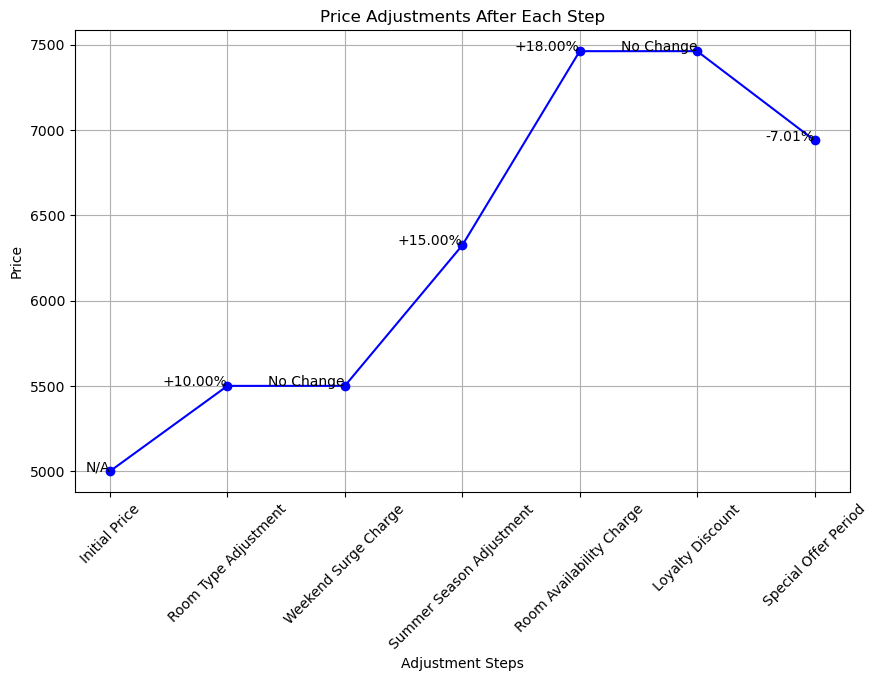

In [21]:
# initial MODEL - BASED ON BOOKING DATE INSTEAD OF CHECK-IN DATE
from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Database connection parameters
username = 'root'
password = 'iamukr77'
host = 'localhost'
port = '3306'  # Default MySQL port
database = 'hms'  # Your schema name

# Create an engine instance with provided credentials
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Define the ORM base class
Base = declarative_base()

# Define the ORM mapping for the rooms table
class Room(Base):
    __tablename__ = 'rooms'
    id = Column(Integer, primary_key=True, autoincrement=True)
    room_no = Column(Integer, unique=True)
    price = Column(Integer)
    room_type = Column(String(2))
    currently_booked = Column(Boolean, default=False)
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="room")

# Define the ORM mapping for the reservations table
class Reservation(Base):
    __tablename__ = 'reservations'
    id = Column(Integer, primary_key=True, autoincrement=True)
    g_id = Column(Integer, ForeignKey('guests.id'))
    r_date = Column(DateTime)
    check_in = Column(DateTime)
    check_out = Column(DateTime)
    meal = Column(Boolean)
    r_id = Column(Integer, ForeignKey('rooms.id'))
    r_type = Column(String(2))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    guest = relationship("Guest", back_populates="reservations")
    room = relationship("Room", back_populates="reservations")

# Define the ORM mapping for the guests table
class Guest(Base):
    __tablename__ = 'guests'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(30))
    address = Column(String(50))
    email_id = Column(String(50))
    phone = Column(Integer)
    city = Column(String(20))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="guest")

# Create a sessionmaker
Session = sessionmaker(bind=engine)

# Function to calculate dynamic price based on room type, weekends, and summer season
def calculate_dynamic_price(room, reservation):
    prices = []
    labels = []
    changes = []
    
    base_price = 5000  # Example base price
    prices.append(base_price)
    labels.append('Initial Price')
    changes.append('N/A')
    print(f"Initial Price: {base_price}")
    
    # Adjust price based on room type
    previous_price = base_price
    if room.room_type == 'D':  # Deluxe room
        base_price += 1000
    elif room.room_type == 'N':  # Normal room
        base_price += 500
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(base_price)
    labels.append('Room Type Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Room Type Adjustment: {base_price} ({changes[-1]})")
    
    # Check if the created_at date was a weekend
    previous_price = base_price
    created_at_date = reservation.created_at
    is_weekend_flag = created_at_date.weekday() >= 5  # 5 represents Saturday, 6 represents Sunday

    if is_weekend_flag:
        base_price *= 1.2  # Increase price by 20% for rooms created on weekends
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Weekend Surge Charge')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Weekend Surge Charge: {int(base_price)} ({changes[-1]})")
    
    # Check if the created_at date falls within the summer season (March and April)
    previous_price = base_price
    if created_at_date.month in [3, 4]:
        base_price *= 1.15  # Increase price by 15% for rooms booked during the summer season
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Summer Season Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Summer Season Adjustment: {int(base_price)} ({changes[-1]})")
    
    return int(base_price), prices, labels, changes

# Function to check if the room is booked
def is_room_booked(room_no, session):
    reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out == None).first()
    return reservation is not None

# Function to apply dynamic price based on room availability
def update_room_price(room_no, session, current_price):
    previous_price = current_price
    if is_room_booked(room_no, session):
        current_price *= 1.18  # Increase price by 18%
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Room Availability Charge: {int(current_price)} ({f'+{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return int(current_price), f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply loyalty discount
def apply_loyalty_discount(current_price, guest):
    previous_price = current_price
    if guest.email_id == 'ukr@abc.com':
        current_price = int(current_price * 0.8)  # Apply 20% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Loyalty Discount: {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply special offer period specific date
def apply_special_offer(current_price, reservation):
    previous_price = current_price
    offer_start_date = datetime.datetime(2024, 3, 10)
    offer_end_date = datetime.datetime(2024, 3, 30)
    
    if offer_start_date <= reservation.created_at <= offer_end_date:
        current_price = int(current_price * 0.93)  # Apply 7% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Special Offer Period: {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Main function to update room price
def update_room_price_main():
    try:
        # Create a session
        session = Session()
        
        # Take room number input from the user
        room_number_to_update = int(input("Enter the room number to update: "))
        
        # Fetch the room with the specific room_no
        room = session.query(Room).filter_by(room_no=room_number_to_update).first()
    
        if room:
            # Fetch the reservation associated with the room
            reservation = session.query(Reservation).filter_by(r_id=room.id, check_out=None).first()
    
            if reservation:
                # Fetch the guest associated with the reservation
                guest = session.query(Guest).filter_by(id=reservation.g_id).first()
    
                # Calculate the new dynamic price
                new_price, prices, labels, changes = calculate_dynamic_price(room, reservation)
    
                # Apply dynamic price based on room availability
                new_price, change = update_room_price(room.room_no, session, new_price)
                prices.append(new_price)
                labels.append('Room Availability Charge')
                changes.append(change)
    
                # Apply loyalty discount if applicable
                new_price, change = apply_loyalty_discount(new_price, guest)
                prices.append(new_price)
                labels.append('Loyalty Discount')
                changes.append(change)
                
                # Apply special offer period specific date
                new_price, change = apply_special_offer(new_price, reservation)
                prices.append(new_price)
                labels.append('Special Offer Period')
                changes.append(change)
    
                # Update the price in the database
                room.price = new_price
                session.commit()  # Commit the changes
                print(f"Final price updated successfully for room {room_number_to_update} to {new_price}.")
                
                # To verify the update, fetch the data again and display the updated DataFrame
                query = f"SELECT * FROM rooms WHERE room_no = {room_number_to_update}"
                data = pd.read_sql(query, engine)
                print(data)
    
                # Plot the price changes
                plt.figure(figsize=(10, 6))
                plt.plot(labels, prices, marker='o', linestyle='-', color='b')
                for i, (label, price, change) in enumerate(zip(labels, prices, changes)):
                    plt.text(i, price, f'{change}', ha='right')
                plt.xlabel('Adjustment Steps')
                plt.ylabel('Price')
                plt.title('Price Adjustments After Each Step')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
            else:
                print(f"No reservation found for room number {room_number_to_update}.")
        else:
            print(f"Room number {room_number_to_update} not found.")
    
    except Exception as e:
        session.rollback()  # Rollback the changes on error
        print(f"An error occurred: {e}")
    finally:
        session.close()  # Close the session

# Execute the main function
if __name__ == "__main__":
    update_room_price_main()
